In [9]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In [7]:
from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='viridis', magnitude= False, lw=5, pixels_per_node=15, x_name='X', y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixel_xscaling_factor)), int(round(grid.number_of_cell_rows*pixel_yscaling_factor)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


In [173]:
mg = RasterModelGrid((5,5),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
C = mg.add_zeros('node', 'concentration')
Q = mg.add_zeros('link', 'conduit__discharge')
C_inflow = mg.add_zeros('node', 'input__concentration')
Cin = mg.add_zeros('link', 'conduit__conc_in')
Cout = mg.add_zeros('link', 'conduit__conc_out')
#set boundary node head

#add input to node 310
input_Q=.05
input_C = 1.
input_idx = 11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['input__concentration'][input_idx] = input_C 

#mg.at_node['input__discharge'][7] = input_Q
#mg.at_node['input__concentration'][7] = 0.1 


#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

C[mg.nodes_at_left_edge] = 0.
C[mg.nodes_at_right_edge] = 0.
C[mg.nodes_at_top_edge] = 0.
C[mg.nodes_at_bottom_edge] = 0.


mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.5*np.random.rand(mg.number_of_active_links)+0.1

#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg)
pfn.run_one_step()


Number of links =  40
Number of nodes =  25
Number of active links =  18
Number of core nodes =  9
Number of iterations = 1 tolerance = 0.0802678417438  iteration time= 0.0043714046478271484
Number of iterations = 2 tolerance = 0.0217350413699  iteration time= 0.0035524368286132812
Number of iterations = 3 tolerance = 0.0067840125132  iteration time= 0.004527568817138672
Number of iterations = 4 tolerance = 0.00177366585964  iteration time= 0.003531932830810547
Number of iterations = 5 tolerance = 0.00085860512293  iteration time= 0.0036115646362304688
Number of iterations = 6 tolerance = 0.000539014305184  iteration time= 0.0032117366790771484
Number of iterations = 7 tolerance = 1.17993344057e-05  iteration time= 0.003801584243774414
Number of iterations = 8 tolerance = 4.42121719775e-07  iteration time= 0.0031282901763916016


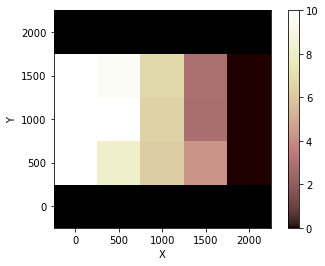

In [174]:
figure()
imshow_grid_at_node(mg, h)


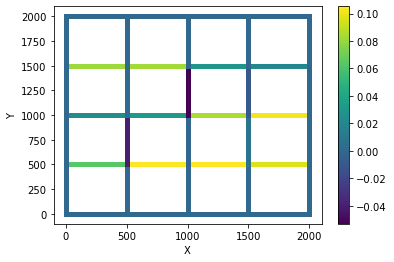

In [175]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=False)

In [176]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h)#Sort on negative to get descending order sort

for node_idx in idx:
    this_node_links = mg.links_at_node[node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[node_idx]

    #First determine inflow and outflow links
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                    mg.at_node['input__discharge'][node_idx]

    if total_inflow !=0:
        conc_mult = np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['conduit__conc_out'][node_inflow_links]
        input_conc_mult = mg.at_node['input__discharge'][node_idx]*mg.at_node['input__concentration'][node_idx]
        conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow
        C[node_idx] = conc_node
    
        #set outflow link concentrations
        mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node
    
        #Calculate output link concentrations (for now conservative)
        mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




In [177]:
mg.at_link['conduit__conc_in']

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.25664353,  0.25671034,  0.25671034,  0.        ,  0.66957209,
        0.26504717,  0.25671034,  0.        ,  0.        ,  0.66957209,
        0.26504717,  0.24119911,  0.        ,  0.66957209,  0.0144084 ,
        0.0144084 ,  0.        ,  0.        ,  0.0144084 ,  0.0144084 ,
        0.0144084 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

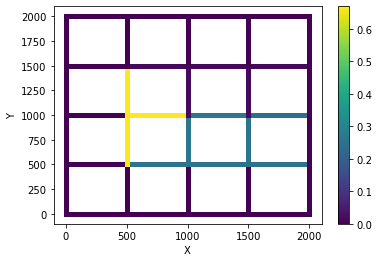

In [178]:
plot_links(mg, 'conduit__conc_in', use_PIL=False)

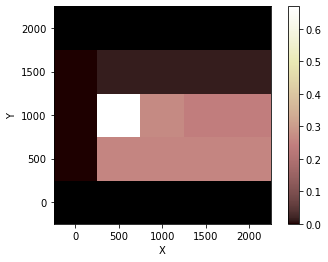

In [179]:
imshow_grid_at_node(mg, C)

In [180]:
C

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.25664353,  0.25671034,  0.25671034,  0.25671034,
        0.        ,  0.66957209,  0.26504717,  0.24119911,  0.24119911,
        0.        ,  0.0144084 ,  0.0144084 ,  0.0144084 ,  0.0144084 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

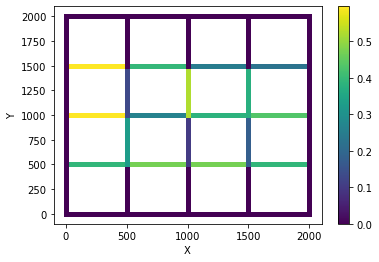

In [181]:
plot_links(mg, 'hydraulic__diameter', use_PIL=False)